# Music Genre Analysis
## Implementation of Bag Of Words technique
To generate the word embeddings, I have chosen the Bag Of Words technique over TfIdf. In the TfIdf technique, the importance of each word is determined by using two factors:


1.Based on the frequency of the word in the document


2.Based on the frequency of the word in the other documents of the corpus

But in this context,each keyword is equally important irrespective of its occurence in other documents.Thus,Bag Of Words is a better alternative.


In [2]:

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Open and read the file
file_path = "TASK2_dataset.csv"
#KEYWORD 1
with open(file_path, "r", newline="", encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    data = list(reader)

# We will be preparing the test data parallelly with the training data so that it will be ready for making predictions at the end


testing_data = [['1','piano', 'calm','slow'], ['2','guitar', 'emotional', 'distorted'], ['3','synth', 'mellow', 'distorted']]


# Convert to DataFrame
df = pd.DataFrame([row[:4] for row in data], columns=["ID", "Keyword1", "Keyword2", "Keyword3"])
df2 = pd.DataFrame([row[:4] for row in testing_data], columns=["ID", "Keyword1", "Keyword2", "Keyword3"])

# Extract unique words per category
Keyword1 = sorted(set(song[1] for song in data))  
Keyword2 = sorted(set(song[2] for song in data))       
Keyword3 = sorted(set(song[3] for song in data))       

# Create dictionary mappings
keyword1_dict = {word: i for i, word in enumerate(Keyword1)}
keyword2_dict = {word: i for i, word in enumerate(Keyword2)}
keyword3_dict = {word: i for i, word in enumerate(Keyword3)}
    
# Apply the Bag Of Words embedding technique for each of the keyword
bow_keyword1 =np.zeros((len(data), len(Keyword1)), dtype=int)
bow_keyword2= np.zeros((len(data), len(Keyword2)), dtype=int)
bow_keyword3= np.zeros((len(data), len(Keyword3)), dtype=int)

# Assign rows dynamically based on unordered song IDs
song_index_map = {row[0]: i for i, row in enumerate(data)}

for row in data:
    song_id,keyword1, keyword2, keyword3 = row[:-1] # Extract fields
    i = song_index_map[song_id]  # Get row index for this song
    bow_keyword1[i, keyword1_dict[keyword1]] = 1
    bow_keyword2[i, keyword2_dict[keyword2]] = 1
    bow_keyword3[i, keyword3_dict[keyword3]] = 1

# For the testing data  
    # Apply the Bag Of Words embedding technique for each of the keyword
bow2_keyword1= np.zeros((3, len(Keyword1)), dtype=int)
bow2_keyword2= np.zeros((3, len(Keyword2)), dtype=int)
bow2_keyword3= np.zeros((3, len(Keyword3)), dtype=int)

    # Assign rows dynamically based on unordered song IDs
song_index_map2 = {row[0]: i for i, row in enumerate(testing_data)}

    
for row in testing_data:
    song_id,keyword1, keyword2, keyword3 = row # Extract fields
    i = song_index_map2[song_id]  # Get row index for this song
    bow2_keyword1[i, keyword1_dict[keyword1]] = 1
    bow2_keyword2[i, keyword2_dict[keyword2]] = 1
    bow2_keyword3[i, keyword3_dict[keyword3]] = 1






ModuleNotFoundError: No module named 'numpy'

## Dimensionality reduction

For dimensionality reduction of the vectors, I have used PCA(Principal Component Analysis) to generate three 2-Dimensional vectors

In [ ]:

class PCA:
    def __init__(self,n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None
    def fit(self,X):
        self.mean = np.mean(X,axis = 0)
        X = X - self.mean
        cov = np.cov(X.T)
        eigenvalues,eigenvectors = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.components = eigenvectors[:self.n_components]
        self.explained_variance = eigenvalues[:self.n_components]
    def transform(self,X):
        X = X - self.mean
        return np.dot(X,self.components.T)
    

# PCA for column 1
pca_col1 = PCA(n_components=2)
pca_col1.fit(bow_keyword1)
X_pca_col1 = pca_col1.transform(bow_keyword1)
var_col1 = np.sum(pca_col1.explained_variance)

# PCA for column 2
pca_col2 = PCA(n_components=2)
pca_col2.fit(bow_keyword2)
X_pca_col2 = pca_col2.transform(bow_keyword2)
var_col2 = np.sum(pca_col2.explained_variance)

# PCA for column 3
pca_col3 = PCA(n_components=2)
pca_col3.fit(bow_keyword3)
X_pca_col3 = pca_col3.transform(bow_keyword3)
var_col3 = np.sum(pca_col3.explained_variance)


#For the testing data
# Apply PCA to each BoW matrix


Y_pca_keyword1 = pca_col1.transform(bow2_keyword1)
Y_pca_keyword2 = pca_col2.transform(bow2_keyword2)
Y_pca_keyword3 = pca_col3.transform(bow2_keyword3)




## Computing the final embedding
To compute the final embedding, I have used the weighted mean method. I have calculated the weights fo the respective 2D vectors using their respective variances.

Higher Variance -> Higher importance -> Higher weight

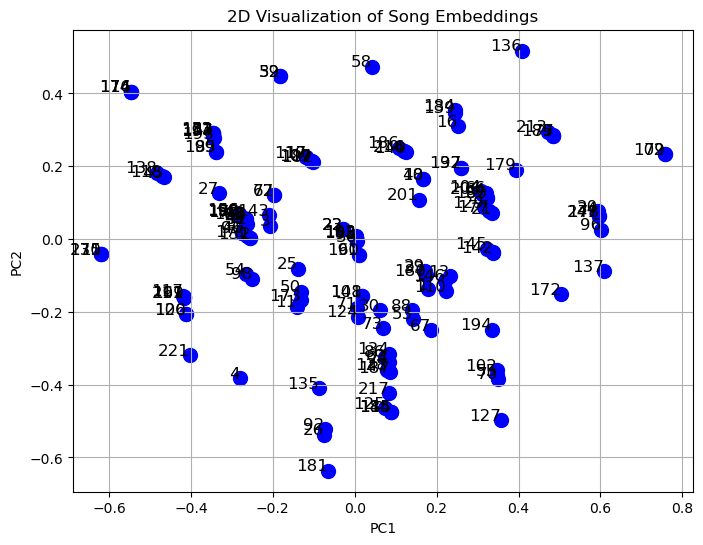

In [ ]:

# Computing the weights based on variance
total_var = var_col1 + var_col2 + var_col3
weight1 = var_col1/total_var
weight2 = var_col2/total_var
weight3 = var_col3/total_var

# Compute Final Weighted Mean Embedding
final_embedding = (
    weight1 * X_pca_col1 + weight2 * X_pca_col2 + weight3 * X_pca_col3
)

# For the testing data

# Compute Final Mean Embedding
final_embedding2 = ( Y_pca_keyword1 + Y_pca_keyword2 + Y_pca_keyword3 ) / 3
   

song_ids = []
for row in data[1:]:
    song_ids.append(row[0])
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(final_embedding[:, 0], final_embedding[:, 1], c='blue', facecolors='black', s=100)

# Annotate each point with its song ID
for i, song_id in enumerate(song_ids):
    plt.annotate(str(song_id), (final_embedding[i, 0], final_embedding[i, 1]), fontsize=12, ha='right')

# Labels and Title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D Visualization of Song Embeddings")
plt.grid(True)

# Show plot
plt.show()




## Clustering
Now that we have our final combined embedding, we need to cluster it. I have used the standard K- means clustering method.
To determine the optimal value of k , we need to plot the graph of 'Variance per cluster' vs 'Value of K'. The value of k will be at the point after which the variance almost remains constant.From the plot shown below, the most appropriate value of k will be 3. 

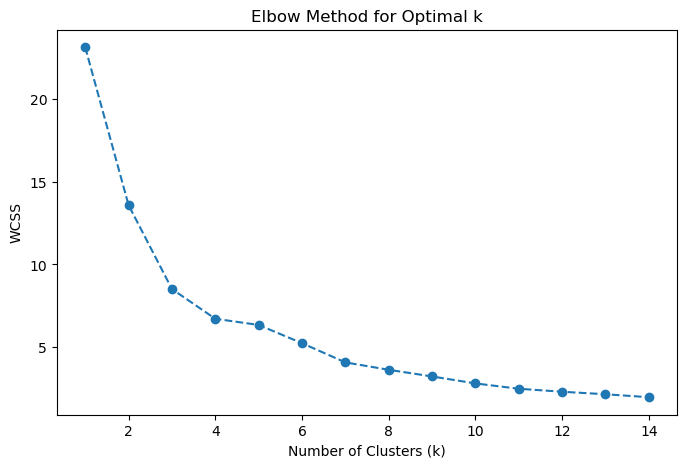

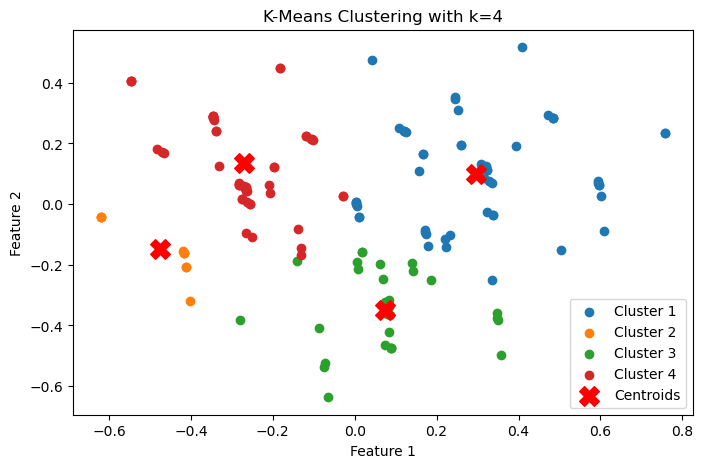

In [ ]:
X = final_embedding
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)


# Using K-means++ algorithm for clustering

def initialisation_of_centroids(X,k):
    np.random.seed(0)
    n_samples,_ = X.shape
    centroids = [X[np.random.randint(n_samples)]]
    for _ in range(1,k):
        distances = np.array([min(distance(x,c) for c in centroids) for x in X])
        probabilities = distances ** 2
        probabilities /= probabilities.sum()
        new_centroid = X[np.random.choice(n_samples,p = probabilities)]
        centroids.append(new_centroid)

    return centroids

def assigning_clusters(X,centroids):
   return np.array([np.argmin([distance(x, c) for c in centroids]) for x in X])

    

def computing_new_centroids(X, labels, k):
    #Compute new centroids, handling empty clusters.
    new_centroids = []
    
    for i in range(k):
        cluster_points = X[labels == i]
        
        if len(cluster_points) == 0:  #  If cluster is empty
            new_centroids.append(X[np.random.randint(len(X))])  #  Reassign a random point
        else:
            new_centroids.append(cluster_points.mean(axis=0))  #  Compute mean normally
    
    return np.array(new_centroids)

def k_meanspp(X,k,max_iters = 200,tol = 1e-4):
    centroids = initialisation_of_centroids(X,k)
    
    for _ in range(max_iters):
        labels = assigning_clusters(X,centroids)
        new_centroids = computing_new_centroids(X,labels,k)
        if np.linalg.norm(centroids - new_centroids) < tol:
            break
        centroids = new_centroids

    return labels,centroids, np.sum((X - centroids[labels])**2)
    


# Compute Within-Cluster Sum of Squares (WCSS) for different k values
wcss = []
k_values = range(1, 15)

for k in k_values:
    labels, centroids, inertia = k_meanspp(X, k)
    wcss.append(inertia)

optimal_k = 4
labels, centroids,_ = k_meanspp(X, optimal_k)

# Plot the elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()


# Plot the clustered data
plt.figure(figsize=(8, 5))
for i in range(optimal_k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.legend()
plt.show()




# Percentage distribution of music genres in each cluster
Now , we find the percentage distributon of music genres (i.e. the ground truths) in each cluster.


Percentage Distribution of Genres in Each Cluster:
Genre    classical    country    hip-hop        pop       rock
Cluster                                                       
0         9.090909   7.272727  50.909091  23.636364   9.090909
1         0.000000  40.000000   0.000000  10.000000  50.000000
2        58.064516  16.129032   3.225806  22.580645   0.000000
3         7.843137  31.372549   1.960784  19.607843  39.215686


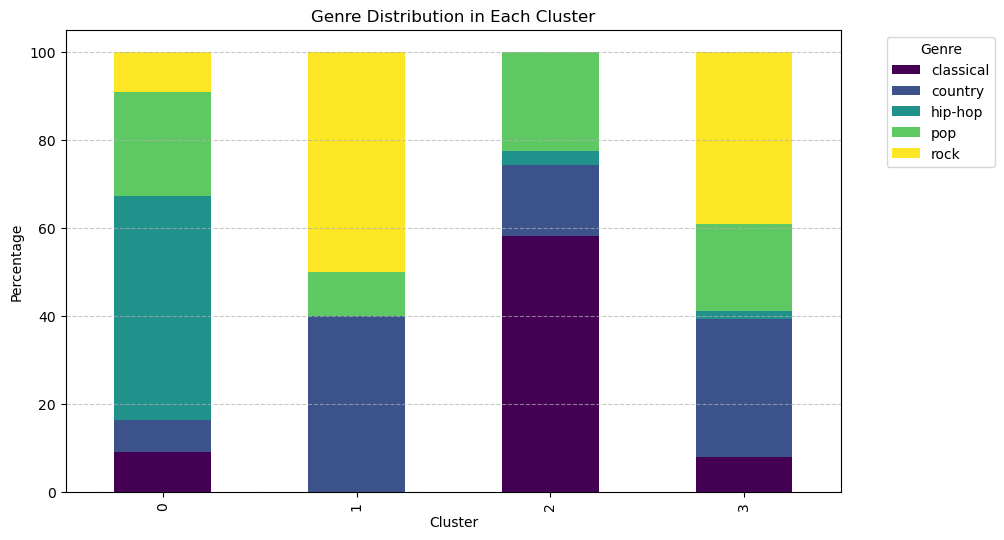

In [ ]:
# Creating a list of all the genres
genres = []

for row in data:
    genres.append(row[4])


# Create DataFrame with Clusters and Genres
df = pd.DataFrame({"Genre": genres, "Cluster": labels})

# Count occurrences of each genre in each cluster
cluster_distribution = df.groupby(["Cluster", "Genre"]).size().unstack(fill_value=0)

# Convert counts to percentages
cluster_distribution_percentage = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0) * 100

# Display the percentage distribution table
print("\nPercentage Distribution of Genres in Each Cluster:")
print(cluster_distribution_percentage)

# Plot the distribution as a stacked bar chart
cluster_distribution_percentage.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Genre Distribution in Each Cluster")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()      






# Silhoutte Score
Calculating the silhoutte score 

Silhoutte score of each data point = (b-a)/max(b,a) where

a = average distance of the data point from all the other data points of the same cluster

b = minimum of the average distances of the data point from the each of the remaining clusters


Silhoutte score of our clustering algorithm gives an idea about how well the clusters are formed.

In [ ]:
# Function to compute Silhouette Score for each data point
def silhouette_score(X, labels):
    unique_clusters = np.unique(labels)
    n = len(X)
    silhouette_scores = np.zeros(n)

    for i in range(n):
        # Get current point and its cluster
        point = X[i]
        cluster = labels[i]

        # Compute a(i): Mean intra-cluster distance
        same_cluster_points = X[labels == cluster]
        a_i = np.mean([distance(point, other) for other in same_cluster_points] )
        
        # Compute b(i): Mean nearest-cluster distance
        nearest_cluster_distances = []
        for other_cluster in unique_clusters:
            if other_cluster == cluster:
                continue  # Skip same cluster

            other_cluster_points = X[labels == other_cluster]
            if len(other_cluster_points) > 0:
                avg_dist = np.mean([distance(point, other) for other in other_cluster_points])
                nearest_cluster_distances.append(avg_dist)

        b_i = min(nearest_cluster_distances) if nearest_cluster_distances else 0

        # Compute Silhouette Score for the point
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0

    # Return average silhouette score for all points
    return np.mean(silhouette_scores)


sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score: .4f}")

Silhouette Score:  0.4113


## Making Predictions
Now, to assign a genre to the given songs described the three keywords each, I am going to use the K-NN Algorithm (or the K nearest neighbours algorithm).We have to assign genres to the following:


[piano, calm, slow],
[guitar, emotional, distorted],
[synth, mellow, distorted]

## Preparing the test data
We have to prepare the test data such that it is present in the same feature space as that of the training data.I have already done that parallelly with the training data.


## KNN Algorithm
The algorithm essentially works by identifying the k nearest data points to the testing data point and makes predictions based on these neighbours

In [ ]:
from collections import Counter
class KNN:
    def __init__(self,k):
        self.k = k
    def fit(self,X_train,Y_train):
        self.X_train = X_train # Storing the training data
        self.Y_train = Y_train # Storing the labels
    def predict(self,testing_data):
        predictions = [self._predict(X) for X in testing_data]
        return np.array(predictions)
    def _predict(self,x):
        distances = [distance(x,X) for X in X_train]
        k_indxs = np.argsort(distances)[::self.k] # Extracting the indices of the k nearest neighbours
        neighbours = [self.Y_train[i] for i in k_indxs]
        # Choosing the genre with the highest votes
        most_common = Counter(neighbours).most_common(1)
        return most_common[0][0]
X_train = final_embedding
Y_train = genres
testing_data = final_embedding2
# I have chosen the value of k as per the square root rule(sqrt(147) ~ 11) where number of training samples = 147
knn = KNN(11)
knn.fit(X_train,Y_train)
predictions = knn.predict(testing_data)
print(predictions)
    

        


['pop' 'classical' 'pop']
